In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV


In [32]:
# Load Data
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")


In [33]:
# Aggregate transaction data per customer
transaction_summary = transactions.groupby('CustomerID').agg(
    TotalSpent=('TotalValue', 'sum'),
    AvgTransactionValue=('TotalValue', 'mean'),
    TotalQuantity=('Quantity', 'sum'),
    Recency=('TransactionDate', lambda x: (pd.to_datetime('today') - pd.to_datetime(x).max()).days)
).reset_index()


In [34]:
# Merge customer profile and transaction data
customer_data = customers.merge(transaction_summary, on='CustomerID', how='left')
customer_data.fillna(0, inplace=True)

In [35]:
# Encoding categorical features
from sklearn import preprocessing 

label_encoder = preprocessing.LabelEncoder() 

customer_data['Region']=label_encoder.fit_transform(customer_data['Region'])


In [36]:
customer_data.head()

,CustomerID,CustomerName,Region,SignupDate,TotalSpent,AvgTransactionValue,TotalQuantity,Recency
0,C0001,Lawrence Carroll,3,2022-07-10,3354.52,670.904,12.0,88.0
1,C0002,Elizabeth Lutz,0,2022-02-13,1862.74,465.685,10.0,57.0
2,C0003,Michael Rivera,3,2024-03-07,2725.38,681.345,14.0,158.0
3,C0004,Kathleen Rodriguez,3,2022-10-09,5354.88,669.360,23.0,37.0
4,C0005,Laura Weber,0,2022-08-15,2034.24,678.080,7.0,86.0


In [37]:
# Selecting Relevant Features
selected_features = ['TotalSpent', 'AvgTransactionValue', 'TotalQuantity', 'Recency'] + list(customer_data.columns[4:])
customer_features = customer_data[selected_features].copy()


In [38]:

# Scaling Numerical Features
scaler = StandardScaler()
numeric_cols = ['TotalSpent', 'AvgTransactionValue', 'TotalQuantity', 'Recency']
customer_features[numeric_cols] = scaler.fit_transform(customer_features[numeric_cols])


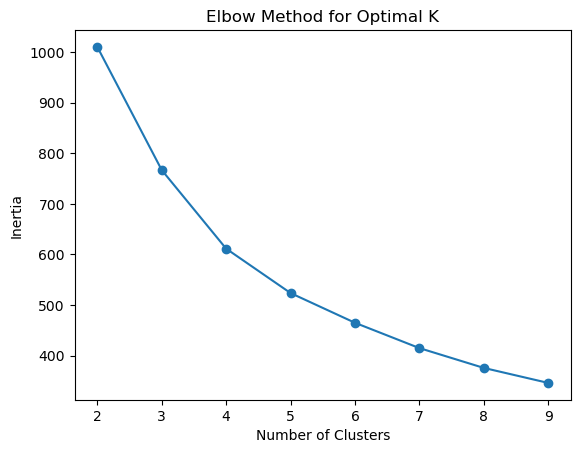

In [39]:
# Finding Optimal Clusters using Elbow Method
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(customer_features)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [55]:
# Choose optimal K (e.g., from Elbow Method) and apply KMeans
optimal_k = 3  # Assume from elbow graph
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
customer_features['Cluster'] = kmeans.fit_predict(customer_features)


In [57]:
# Evaluate Clustering Performance
db_index = davies_bouldin_score(customer_features.drop(columns=['Cluster']), customer_features['Cluster'])
sil_score = silhouette_score(customer_features.drop(columns=['Cluster']), customer_features['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {sil_score}')


Davies-Bouldin Index: 0.9932348016889613
Silhouette Score: 0.3531298901133262


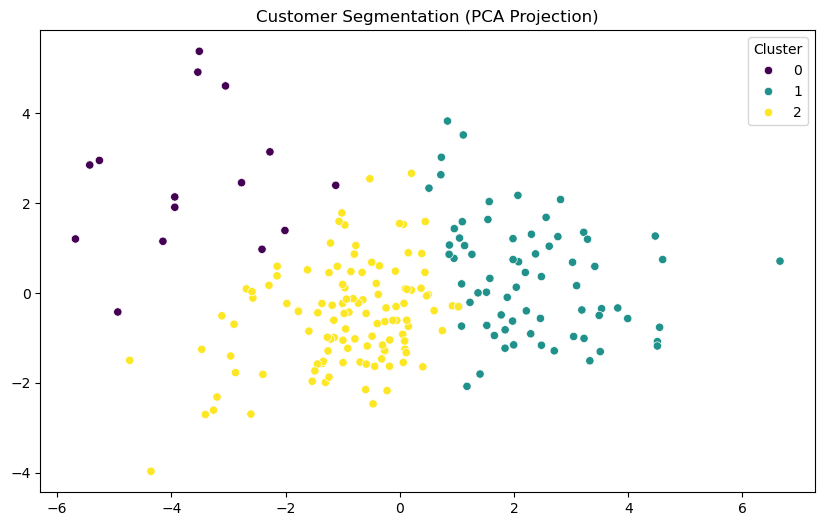

In [59]:
# Visualizing Clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(customer_features.drop(columns=['Cluster']))
plt.figure(figsize=(10,6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=customer_features['Cluster'], palette='viridis')
plt.title('Customer Segmentation (PCA Projection)')
plt.show()
